In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode

BASE = "https://data.cityofchicago.org/resource/ijzp-q8t2.json"

def fetch_chicago_crime(where, limit=50000, max_rows=150000):
    """
    Pulls Chicago crime data from Socrata with pagination.
    - where: Socrata $where clause
    - limit: page size (Socrata often allows up to 50k)
    - max_rows: safety cap so you don’t accidentally pull millions
    """
    all_rows = []
    offset = 0

    while True:
        params = {
            "$select": "id,case_number,date,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,year,latitude,longitude",
            "$where": where,
            "$limit": limit,
            "$offset": offset,
            "$order": "date ASC"
        }

        r = requests.get(BASE, params=params, timeout=60)
        r.raise_for_status()
        batch = r.json()

        if not batch:
            break

        all_rows.extend(batch)
        offset += limit

        print(f"Fetched {len(all_rows):,} rows...")

        if len(all_rows) >= max_rows:
            print("Reached max_rows cap, stopping.")
            break

    df = pd.DataFrame(all_rows)

    # Clean / types
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")

    for col in ["beat","district","ward","community_area","year"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    for col in ["latitude","longitude"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

# Example: 2023 only
where_2023 = "date between '2023-01-01T00:00:00' and '2023-12-31T23:59:59'"

df = fetch_chicago_crime(where_2023, limit=50000, max_rows=200000)
df.shape, df.head()


Fetched 50,000 rows...
Fetched 100,000 rows...
Fetched 150,000 rows...
Fetched 200,000 rows...
Reached max_rows cap, stopping.


((200000, 15),
          id case_number       date                primary_type  \
 0  13140855    JG341458 2023-01-01  OFFENSE INVOLVING CHILDREN   
 1  12938772    JG100243 2023-01-01     CRIMINAL SEXUAL ASSAULT   
 2  13347280    JH126993 2023-01-01          DECEPTIVE PRACTICE   
 3  13434255    JH231395 2023-01-01          DECEPTIVE PRACTICE   
 4  13060487    JG245349 2023-01-01  OFFENSE INVOLVING CHILDREN   
 
                                          description location_description  \
 0  AGGRAVATED SEXUAL ASSAULT OF CHILD BY FAMILY M...            APARTMENT   
 1                                          PREDATORY            RESIDENCE   
 2                                       EMBEZZLEMENT      OTHER (SPECIFY)   
 3                FINANCIAL IDENTITY THEFT OVER $ 300            RESIDENCE   
 4  AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER            RESIDENCE   
 
    arrest  domestic  beat  district  ward  community_area  year   latitude  \
 0   False      True   414      

In [2]:
import pandas as pd
import requests

BASE_URL = "https://data.cityofchicago.org/resource/ijzp-q8t2.json"

def fetch_chicago_crime(limit=50000, max_rows=300000):

    where_clause = """
    date between '2015-01-01T00:00:00'
    and '2025-12-31T23:59:59'
    """

    all_rows = []
    offset = 0

    while True:
        params = {
            "$select": "id,case_number,date,primary_type,description,arrest,domestic,beat,district,community_area,latitude,longitude",
            "$where": where_clause,
            "$limit": limit,
            "$offset": offset,
            "$order": "date ASC"
        }

        r = requests.get(BASE_URL, params=params, timeout=60)
        r.raise_for_status()
        batch = r.json()

        if not batch:
            break

        all_rows.extend(batch)
        offset += limit

        print(f"Fetched {len(all_rows):,} rows")

        if len(all_rows) >= max_rows:
            print("Reached max_rows safety limit")
            break

    df = pd.DataFrame(all_rows)

    # Clean types
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["hour"] = df["date"].dt.hour

    df["arrest"] = df["arrest"].astype(str).str.lower().map({"true":1,"false":0})
    df["domestic"] = df["domestic"].astype(str).str.lower().map({"true":1,"false":0})

    return df


df = fetch_chicago_crime()

df.shape
df.head()


Fetched 50,000 rows
Fetched 100,000 rows
Fetched 150,000 rows
Fetched 200,000 rows
Fetched 250,000 rows
Fetched 300,000 rows
Reached max_rows safety limit


,id,case_number,date,primary_type,description,arrest,domestic,beat,district,community_area,latitude,longitude,year,month,hour
0,13711023,JJ103490,2015-01-01,DECEPTIVE PRACTICE,UNAUTHORIZED VIDEOTAPING,0,1,2222,022,71,NaN,NaN,2015,1,0
1,13368845,JH152261,2015-01-01,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,0,0,0111,001,32,NaN,NaN,2015,1,0
2,13448318,JH247450,2015-01-01,OFFENSE INVOLVING CHILDREN,AGGRAVATED SEXUAL ASSAULT OF CHILD BY FAMILY M...,0,1,1531,015,25,NaN,NaN,2015,1,0
3,13307644,JG540876,2015-01-01,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,0,0,2514,025,19,NaN,NaN,2015,1,0
4,13734810,JJ132359,2015-01-01,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,0,0,0532,005,53,NaN,NaN,2015,1,0


In [3]:
import sqlite3

conn = sqlite3.connect("crime.db")

df.to_sql("crime", conn, if_exists="replace", index=False)

print("SQL table created: crime")


SQL table created: crime


In [4]:
query = """
SELECT
    year,
    primary_type,
    COUNT(*) AS incidents,
    AVG(arrest) AS arrest_rate
FROM crime
GROUP BY year, primary_type
ORDER BY year ASC, incidents DESC
"""

trend = pd.read_sql_query(query, conn)

trend.head()


,year,primary_type,incidents,arrest_rate
0,2015,THEFT,57353,0.118146
1,2015,BATTERY,48927,0.236393
2,2015,CRIMINAL DAMAGE,28677,0.063989
3,2015,NARCOTICS,23939,0.999666
4,2015,OTHER OFFENSE,17566,0.273084


In [5]:
trend.info()
trend.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          62 non-null     int64  
 1   primary_type  62 non-null     object 
 2   incidents     62 non-null     int64  
 3   arrest_rate   62 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.1+ KB


,year,incidents,arrest_rate
count,62.000000,62.000000,62.000000
mean,2015.483871,4838.709677,0.452391
std,0.503819,10775.789584,0.377718
min,2015.000000,1.000000,0.030303
25%,2015.000000,53.500000,0.123802
50%,2015.000000,448.000000,0.244105
75%,2016.000000,2783.500000,0.912354
max,2016.000000,57353.000000,1.000000


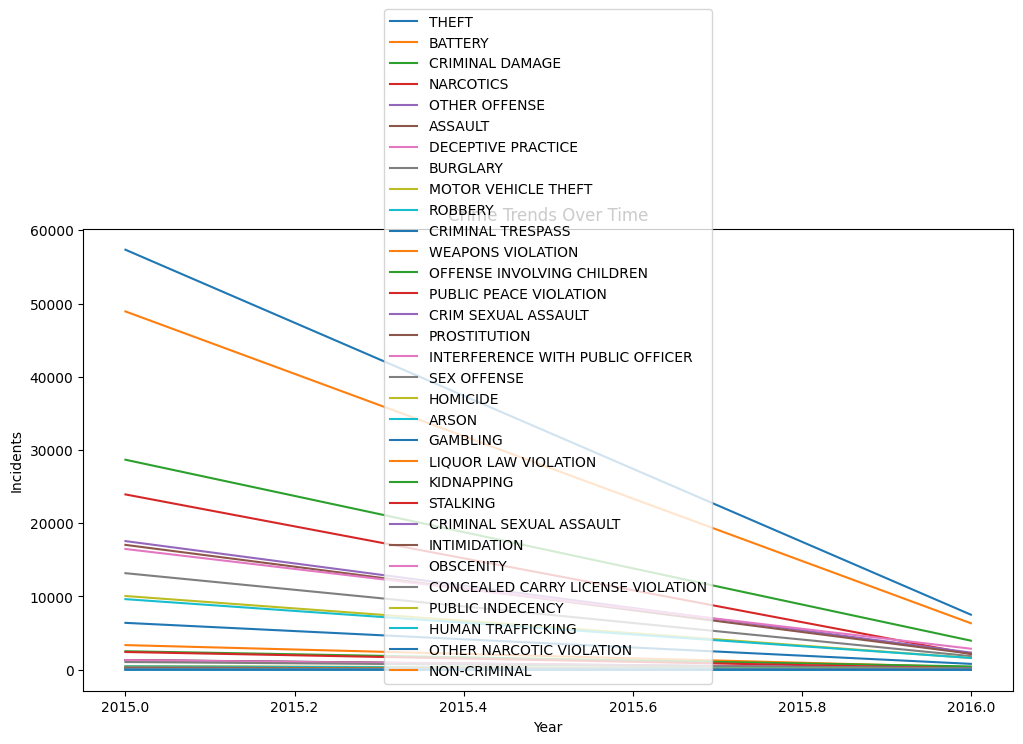

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

for crime in trend['primary_type'].unique():
    subset = trend[trend['primary_type'] == crime]
    plt.plot(subset['year'], subset['incidents'], label=crime)

plt.legend()
plt.title("Crime Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Incidents")
plt.show()


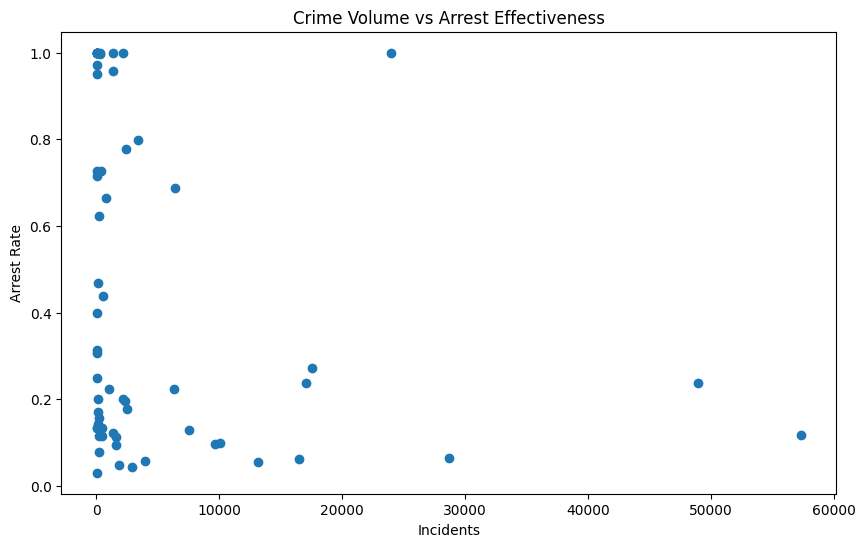

In [7]:
plt.figure(figsize=(10,6))

plt.scatter(
    trend['incidents'],
    trend['arrest_rate']
)

plt.xlabel("Incidents")
plt.ylabel("Arrest Rate")
plt.title("Crime Volume vs Arrest Effectiveness")

plt.show()


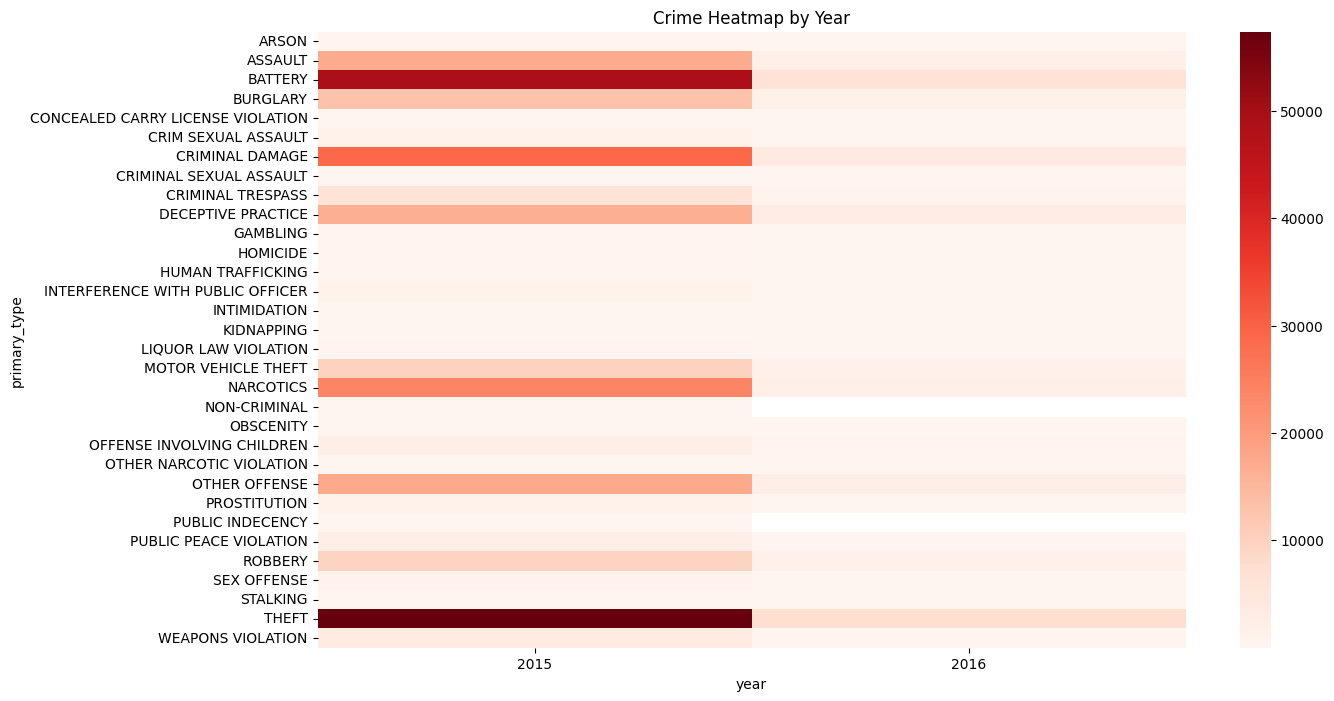

In [10]:
pivot = trend.pivot(
    index='primary_type',
    columns='year',
    values='incidents'
)

import seaborn as sns

plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap="Reds")

plt.title("Crime Heatmap by Year")
plt.show()


In [13]:
import pandas as pd

tables = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;",
    conn
)
tables


,name
0,crime


In [14]:
query = """
SELECT
  primary_type,
  year,
  AVG(arrest) AS arrest_rate
FROM crime
GROUP BY primary_type, year
ORDER BY primary_type, year;
"""

trend = pd.read_sql_query(query, conn)
trend.head()


,primary_type,year,arrest_rate
0,ARSON,2015,0.114790
1,ARSON,2016,0.134328
2,ASSAULT,2015,0.238210
3,ASSAULT,2016,0.199909
4,BATTERY,2015,0.236393


In [16]:
pivot = trend.pivot(
    index="primary_type",
    columns="year",
    values="arrest_rate"
)


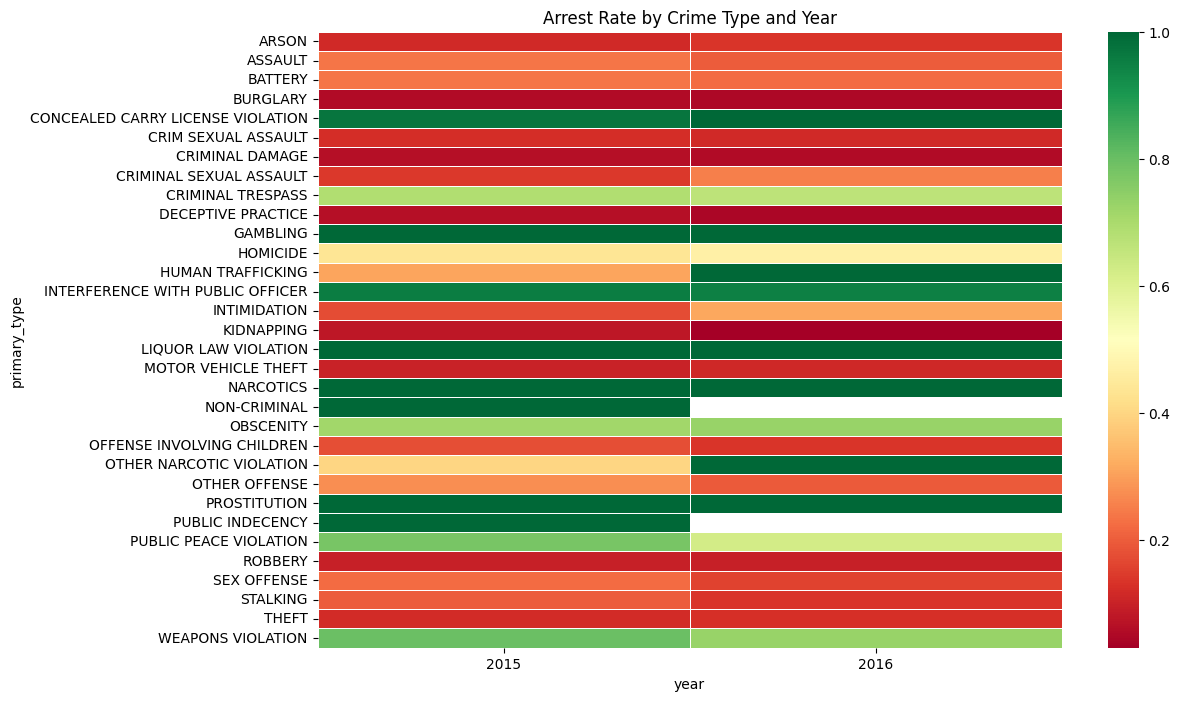

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap="RdYlGn", linewidths=0.5)
plt.title("Arrest Rate by Crime Type and Year")
plt.show()


In [33]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [19]:
monthly_city = pd.read_sql_query("""
SELECT
  year,
  month,
  COUNT(*) AS incidents,
  AVG(arrest) AS arrest_rate
FROM crime
WHERE year BETWEEN 2015 AND 2025
GROUP BY year, month
ORDER BY year, month;
""", conn)

monthly_city["ym"] = pd.to_datetime(monthly_city["year"].astype(str) + "-" + monthly_city["month"].astype(str) + "-01")
monthly_city = monthly_city.sort_values("ym")
monthly_city.head()


,year,month,incidents,arrest_rate,ym
0,2015,1,21017,0.294809,2015-01-01
1,2015,2,16410,0.314321,2015-02-01
2,2015,3,21693,0.304568,2015-03-01
3,2015,4,21745,0.274224,2015-04-01
4,2015,5,23731,0.266150,2015-05-01


In [20]:
def rolling_zscore(series, window=12):
    roll_mean = series.rolling(window, min_periods=max(3, window//3)).mean()
    roll_std  = series.rolling(window, min_periods=max(3, window//3)).std(ddof=0)
    z = (series - roll_mean) / roll_std.replace(0, np.nan)
    return z

monthly_city["z_12"] = rolling_zscore(monthly_city["incidents"], window=12)

# pick a threshold (2.5 is common, 3.0 is stricter)
threshold = 2.5
monthly_city["spike_flag"] = monthly_city["z_12"] >= threshold

monthly_city.loc[monthly_city["spike_flag"], ["ym","incidents","z_12"]].tail(20)


,ym,incidents,z_12


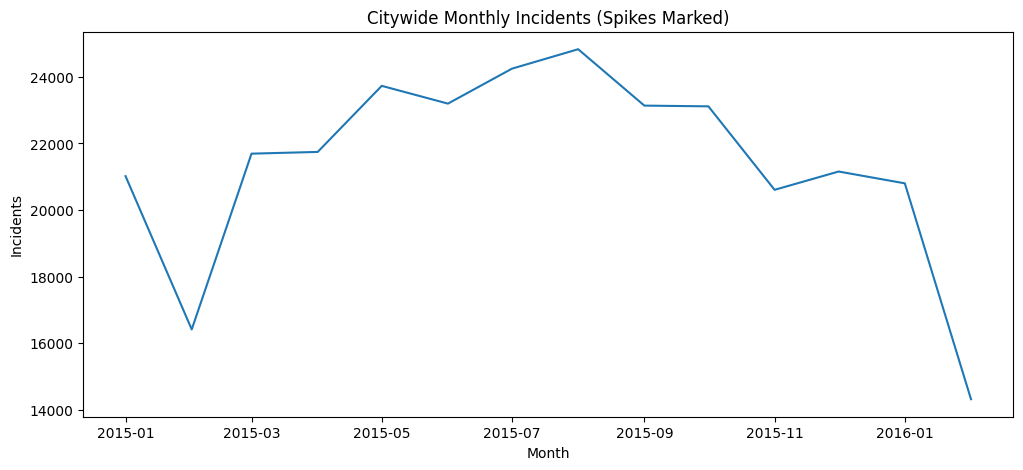

In [21]:
plt.figure(figsize=(12,5))
plt.plot(monthly_city["ym"], monthly_city["incidents"])
spikes = monthly_city[monthly_city["spike_flag"]]
plt.scatter(spikes["ym"], spikes["incidents"])
plt.title("Citywide Monthly Incidents (Spikes Marked)")
plt.xlabel("Month")
plt.ylabel("Incidents")
plt.show()


In [22]:
topN = pd.read_sql_query("""
SELECT primary_type, COUNT(*) AS n
FROM crime
WHERE year BETWEEN 2015 AND 2025
GROUP BY primary_type
ORDER BY n DESC
LIMIT 10;
""", conn)

top_types = topN["primary_type"].tolist()
top_types


['THEFT',
 'BATTERY',
 'CRIMINAL DAMAGE',
 'NARCOTICS',
 'OTHER OFFENSE',
 'DECEPTIVE PRACTICE',
 'ASSAULT',
 'BURGLARY',
 'MOTOR VEHICLE THEFT',
 'ROBBERY']

In [23]:
monthly_type = pd.read_sql_query("""
SELECT
  primary_type,
  year,
  month,
  COUNT(*) AS incidents,
  AVG(arrest) AS arrest_rate
FROM crime
WHERE year BETWEEN 2015 AND 2025
GROUP BY primary_type, year, month
ORDER BY primary_type, year, month;
""", conn)

monthly_type["ym"] = pd.to_datetime(monthly_type["year"].astype(str) + "-" + monthly_type["month"].astype(str) + "-01")
monthly_type = monthly_type[monthly_type["primary_type"].isin(top_types)].copy()
monthly_type = monthly_type.sort_values(["primary_type","ym"])


In [24]:
# compute rolling z-score per type
monthly_type["z_12"] = (
    monthly_type
    .groupby("primary_type")["incidents"]
    .transform(lambda s: rolling_zscore(s, window=12))
)

monthly_type["spike_flag"] = monthly_type["z_12"] >= 2.5

# show most extreme spikes
monthly_type.sort_values("z_12", ascending=False).head(20)[
    ["primary_type","ym","incidents","z_12","arrest_rate"]
]


,primary_type,ym,incidents,z_12,arrest_rate
136,DECEPTIVE PRACTICE,2016-01-01,1671,2.675962,0.037104
18,ASSAULT,2015-05-01,1676,1.553943,0.248210
352,ROBBERY,2015-07-01,916,1.530033,0.109170
357,ROBBERY,2015-12-01,1039,1.486959,0.073147
32,BATTERY,2015-05-01,4892,1.468510,0.227923
297,OTHER OFFENSE,2015-05-01,1679,1.445025,0.276355
53,BURGLARY,2015-12-01,1376,1.428089,0.053052
237,MOTOR VEHICLE THEFT,2015-08-01,967,1.415493,0.071355
242,MOTOR VEHICLE THEFT,2016-01-01,983,1.359817,0.107833
395,THEFT,2015-08-01,5629,1.351051,0.101794


In [25]:
ts = monthly_city.set_index("ym")["incidents"].asfreq("MS")  # Monthly start frequency
ts = ts.fillna(0)

train = ts[:"2024-12-01"]
test  = ts["2025-01-01":]

len(train), len(test), train.index.min(), train.index.max(), test.index.min(), test.index.max()


(14,
 0,
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2016-02-01 00:00:00'),
 NaT,
 NaT)

In [26]:
season = 12
pred_baseline = test.copy()

# shift by 12 months
pred_baseline[:] = ts.shift(season).reindex(test.index).values

mae_baseline = np.mean(np.abs(test - pred_baseline))
print("Baseline MAE:", mae_baseline)


Baseline MAE: nan


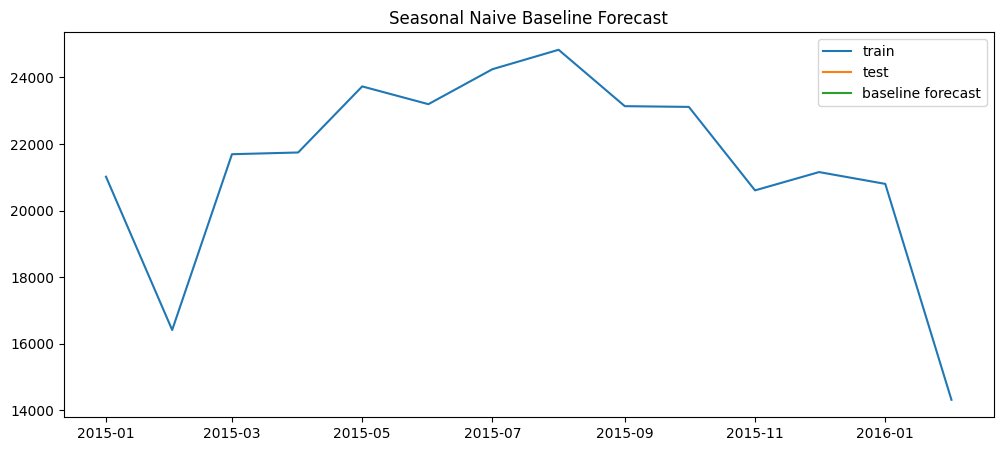

In [27]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train.values, label="train")
plt.plot(test.index, test.values, label="test")
plt.plot(test.index, pred_baseline.values, label="baseline forecast")
plt.legend()
plt.title("Seasonal Naive Baseline Forecast")
plt.show()


In [28]:
!pip -q install statsmodels


In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# A common starting model for monthly seasonality:
# (p,d,q) = (1,1,1) and seasonal (P,D,Q,12) = (1,1,1,12)
model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

fit = model.fit(disp=False)
print(fit.summary().tables[1])


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [30]:
print(type(train))
print(getattr(train, "shape", None))
print(train.head() if hasattr(train, "head") else train)
print("len(train):", len(train) if hasattr(train, "__len__") else "n/a")


<class 'pandas.core.series.Series'>
(14,)
ym
2015-01-01    21017
2015-02-01    16410
2015-03-01    21693
2015-04-01    21745
2015-05-01    23731
Freq: MS, Name: incidents, dtype: int64
len(train): 14


In [31]:
pd.read_sql_query("""
SELECT MIN(year) AS min_year,
       MAX(year) AS max_year,
       COUNT(*)  AS rows
FROM crime;
""", conn)


,min_year,max_year,rows
0,2015,2016,300000


In [32]:
monthly_city = pd.read_sql_query("""
SELECT year, month, COUNT(*) AS incidents
FROM crime
WHERE year BETWEEN 2015 AND 2025
GROUP BY year, month
ORDER BY year, month;
""", conn)

monthly_city["ym"] = pd.to_datetime(
    monthly_city["year"].astype(int).astype(str) + "-" +
    monthly_city["month"].astype(int).astype(str).str.zfill(2) + "-01"
)

ts = (monthly_city
      .set_index("ym")["incidents"]
      .astype(float)
      .asfreq("MS")
      .fillna(0.0)
)

print("TS range:", ts.index.min(), "to", ts.index.max(), "months:", len(ts))
ts.tail()


TS range: 2015-01-01 00:00:00 to 2016-02-01 00:00:00 months: 14


,incidents
ym,
2015-10-01,23115.0
2015-11-01,20606.0
2015-12-01,21156.0
2016-01-01,20801.0
2016-02-01,14312.0
